# RNN Seq2Seq to Attention and Forward!

Last we saw how RNN in Seq2Seq models faces the following bottlenecks:
1. Single vector representing the entire information captured in the encoder step which is unable to represent the word level information in the sequence properly.
2. Relevant word distance from the word being generated. 
3. Sequential processing due to dependence on previous time step calculations.

We also saw how the first and second issue were resolved with the introduction of attention to the RNN-based Seq2Seq model. The inclusion of attention weighted vectors (softmaxed over the dot product of decoder input hidden state and all the encoder hidden states) acting as a soft focus/weighing mechanism to consider the importance and context of each word in the sequence that came as a precursor to the word being generated now, acted as a huge improvement to the purely RNN based Seq2Seq models.

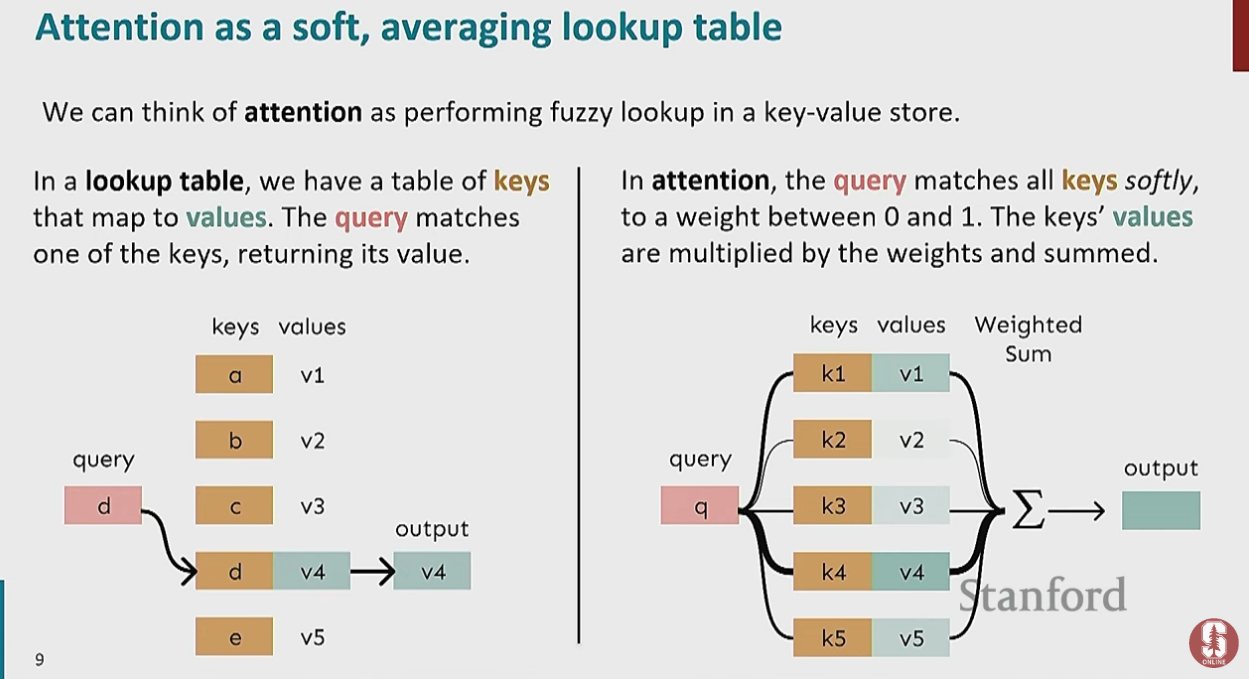

Source: https://www.youtube.com/watch?v=LWMzyfvuehA

But we are yet to resolve the sequential processing problem which turns out to be a major bottleneck in model training from a time complexity, implementation and engineering perspective.
<b>To be able to do that the next idea is to do away with RNNs and work with attention mechanism only.</b>

As the above infographic from Stanford lecture slides stated, we should look at attention as a way to query a lookup table which has many keys and get the weighted sum of the values to maintain the soft focus instead of a 0/1 like hard-match which would have forced us to focus on only 1 value per query. 

But now that we are using attention only, it has its own varieties and types which are needed to capture complicated information. This walkthrough will build the reader up from simple to more complicated process in attention and finally lead to understanding transformers so this notebook may end up being longer than the others in this series. 

# 1. Self Attention

Usually the easiest to understand and begin with, self-attention works by focusing on the input sequence and seeing how similar each word is to the all the words (including itself) in the sequence. 

For e.g. the sequence, "The dog loved the toy, it was very excited.' Here the word 'it' may have higher similarities to both the dog and toy but still higher to the dog as the sentence further talks about 'it' being 'excited'. 

So the attention mechanism will take this sequence in and from the word embeddings which would be non-contextual, meaning the embeddings of each word are static or independent of the surrounding words, the final result would be that the embeddings would become contextually relevant.

So in relevance to the above example, it means that the embedding for the word 'it' would be more influenced by the presence of the word 'dog' here.

Now let's see how self attention works!

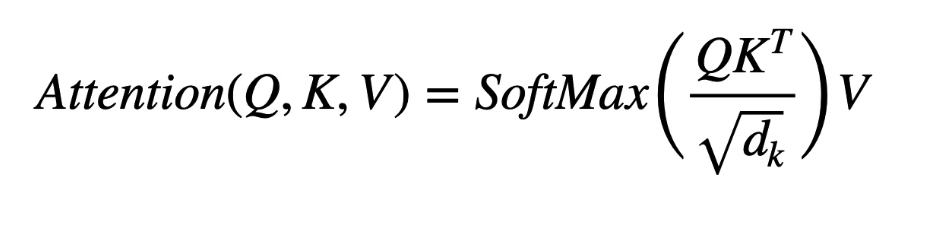

source: https://learn.deeplearning.ai/courses/attention-in-transformers-concepts-and-code-in-pytorch/

## Working:
1. Having the mechanism of a lookup table in our mind, we need to randomly initialize the vectors Q, K and V in $R(d$ x $d)$ where d is the dimension/length of the non-contextual embedding vector of the input word. (Each word will have a vector of the same embedding dimension representing it.) We make these $d by $d because we want the final embedding to still end up being length $d.
2. Then to these embedding vectors we would add a position encoding vector which is basically $N$ randomly initialized vectors that will also be trained as a learnable parameter in model training. But the important point is that the position vector would always be the same for the particular position across all input sequences. (P.S. This $N$ also tends to become the upperlimit of the number of input tokens(words or subwords) that a model can process)
3. Till now what we'll have is $n$ static + position vectors for an $n$ length sequence. Let's denote these vectors $xi$ for each $ith$ word in the sequence.
4. Now we begin the process of calculating self-attention:
    1. To represent each word in the sequence in a single matrix, make a combined matrix $X$ in $R(n$ x $d)$ and multiply it with Q, K and V vectors.
    2. This would be like getting various vector-transformed versions of $X$
    3. Then matrix-multiply Q with K transpose. This would be doing a dot-product (unscaled-similarity score) operation for each word with all the words in the sequence. Where the similarity is higher, the value would end up being higher. This also demonstrates the influence of the word on that other word's contextual embedding. This operation would give us a $n$ x $n$ matrix of course as it would denote the similarity score for each each word with all other words.
    4. Next the resulting matrix is divided by square root of $d$ in an effort to scale the scores, which the authors of transformers claim to work best.
    5. This gives us the entire terms to run through the softmax function. The softmax of this matrix gives us a matrix where the sum of each row is 1 and the values in the rows now represent the relative influence of the words in the columns over the word which makes that row.
    6. Now the above matrix is multiplied with V to get a final matrix in $R(n$ x $d)$ such that it is a weighted sum of the values in V for each word where the weight signifies the influence of other words on it. This becomes the self-attention score for each word.
5. We have the attention averaged values of $V$ now but there's no concept of non-linearity in the picture yet. Even if we add more attention layers on top it would only be re-averaging the values we got. So to help the model capture non-linear patterns better we add a feed-forward NN layer with a <b>non-linear activation function (of course!)</b>


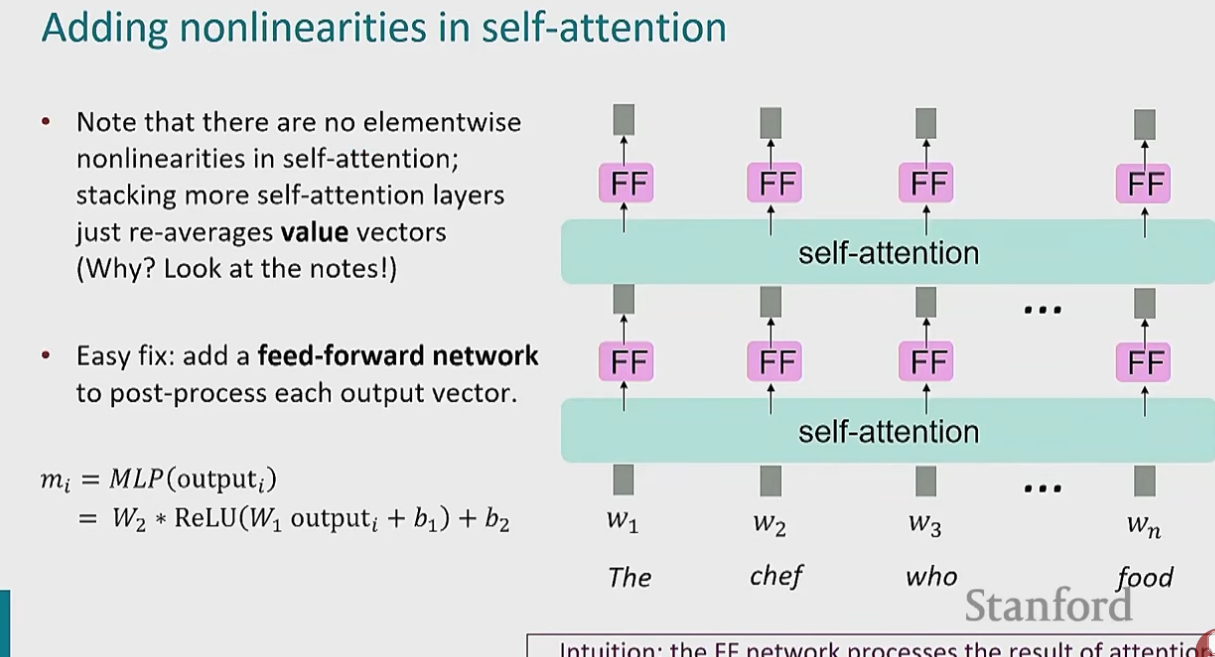

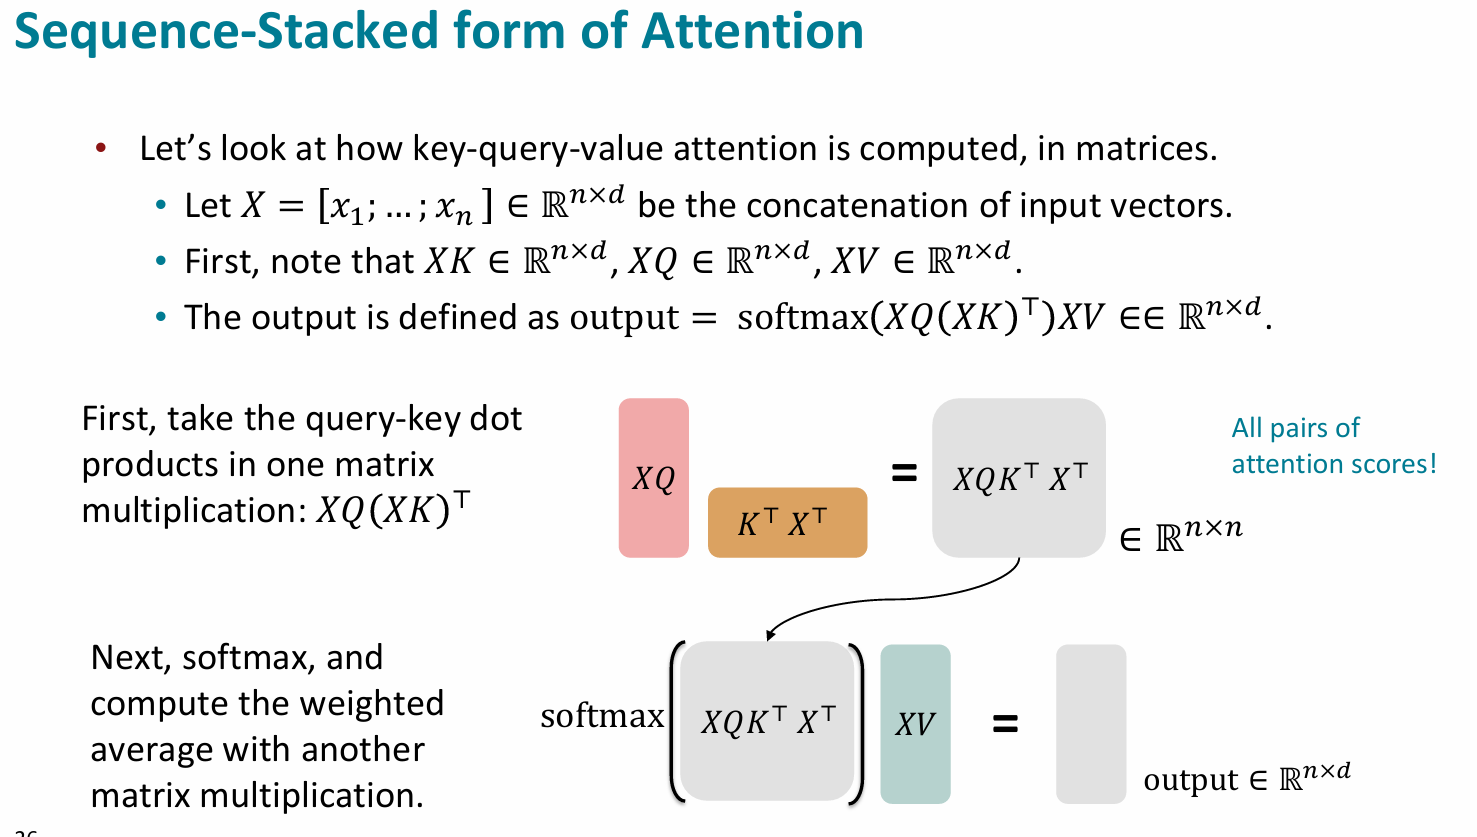

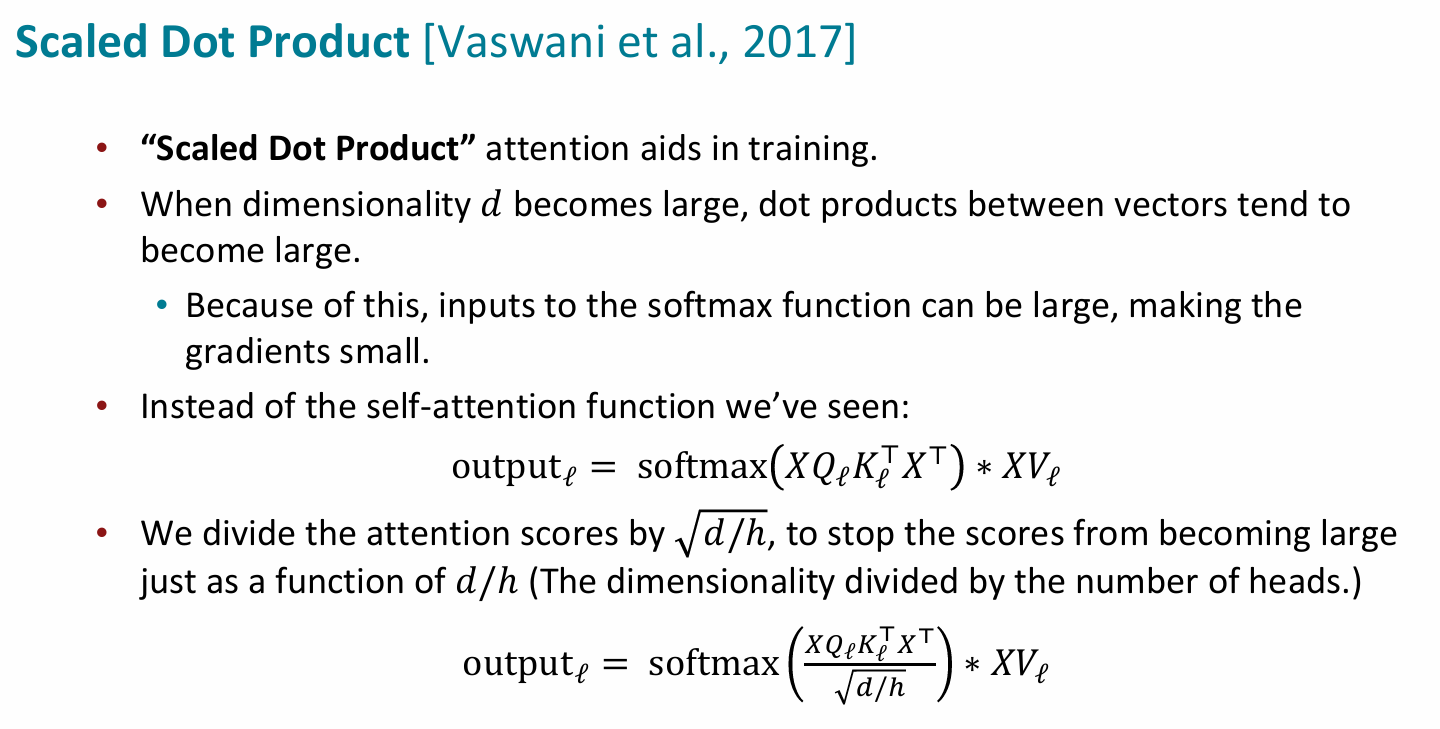


Source: https://www.youtube.com/watch?v=LWMzyfvuehA


### Note

I asked generative models for a detailed answer on why use Q,K and V matrices for this calculation instead of directly using embeddings :-

In attention mechanisms, the Q (Query), K (Key), and V (Value) matrices help to determine the importance of each word in a sequence in relation to others.

Here’s why we use these separate matrices:

1. **Flexibility**: Using Q, K, and V matrices allows for more flexible and dynamic interactions between different parts of the sequence. Each of these matrices can be learned differently, providing a richer representation.

2. **Dimensionality**: The dimensions of the sequence embedding might not be suitable for the type of interactions we want to model. By projecting into different spaces (using Q, K, and V), we can better capture the relationships.

3. **Specialization**: Each of these matrices (Q, K, and V) serves a specific role:
   - **Query (Q)**: Helps to ask the question about the importance of other words.
   - **Key (K)**: Provides context about the importance of each word.
   - **Value (V)**: Contains the actual information to be processed.

By separating these roles, the model can more effectively learn to weigh and interpret the sequence data.


The flexibility point is especially helpful in multi-headed attention that we'll check out in this notebook later.

# 2. Multi Headed Self Attention

It is the repetition of self attention (not stacking) in parallel with different Q,K and V values (mostly also with smaller dimensions than a single self attention layer d/h where h denotes the number of attention heads used). It allows the model to look at the sentence from various perspectives.

How many attention heads to use can depend on multiple factors. One of the factors may be the vector dimension of the model, so if the model is operating on 128 dim vector then it may be useful to set 2 heads with 64 dim vector setup in each so that it can later be concatenated into one single response vector.

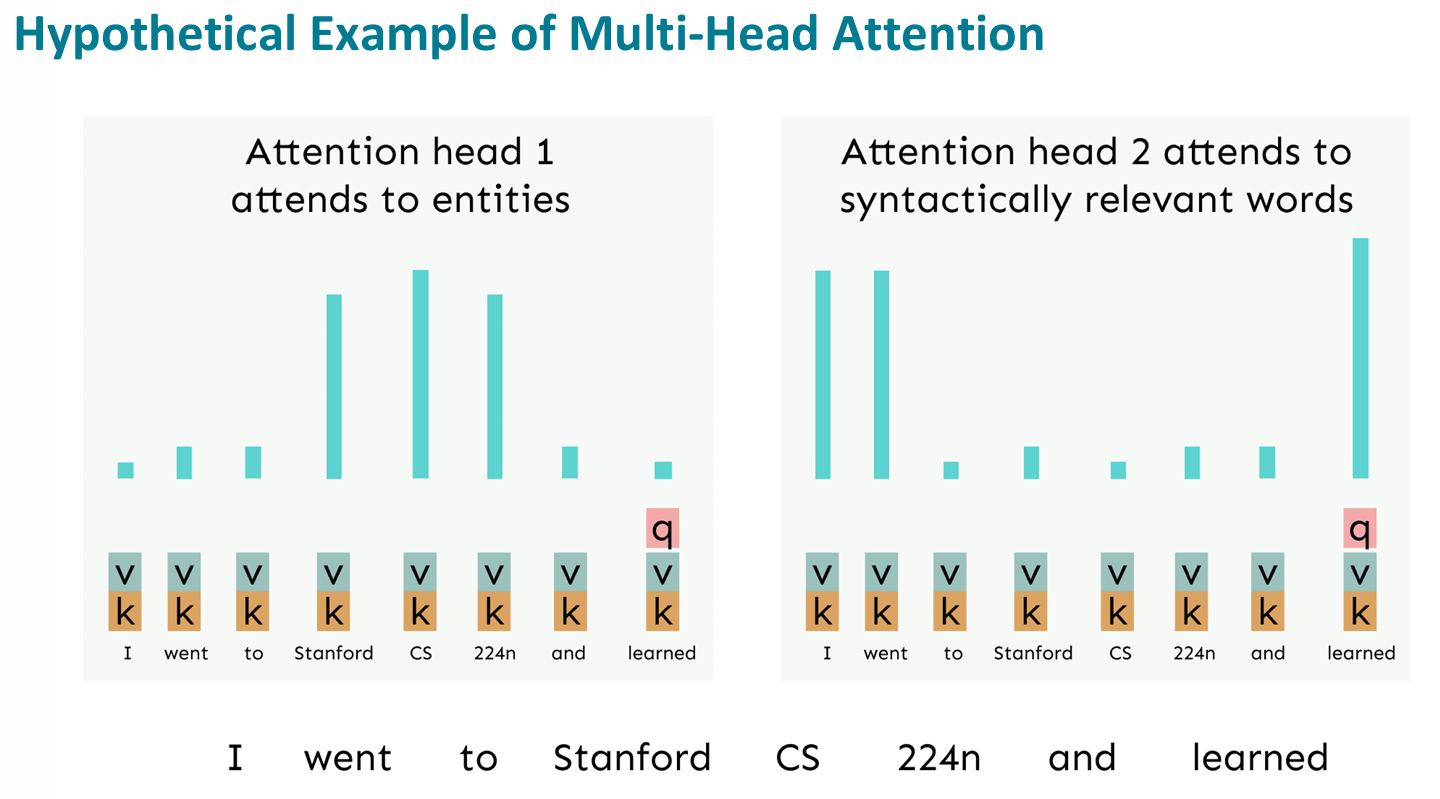


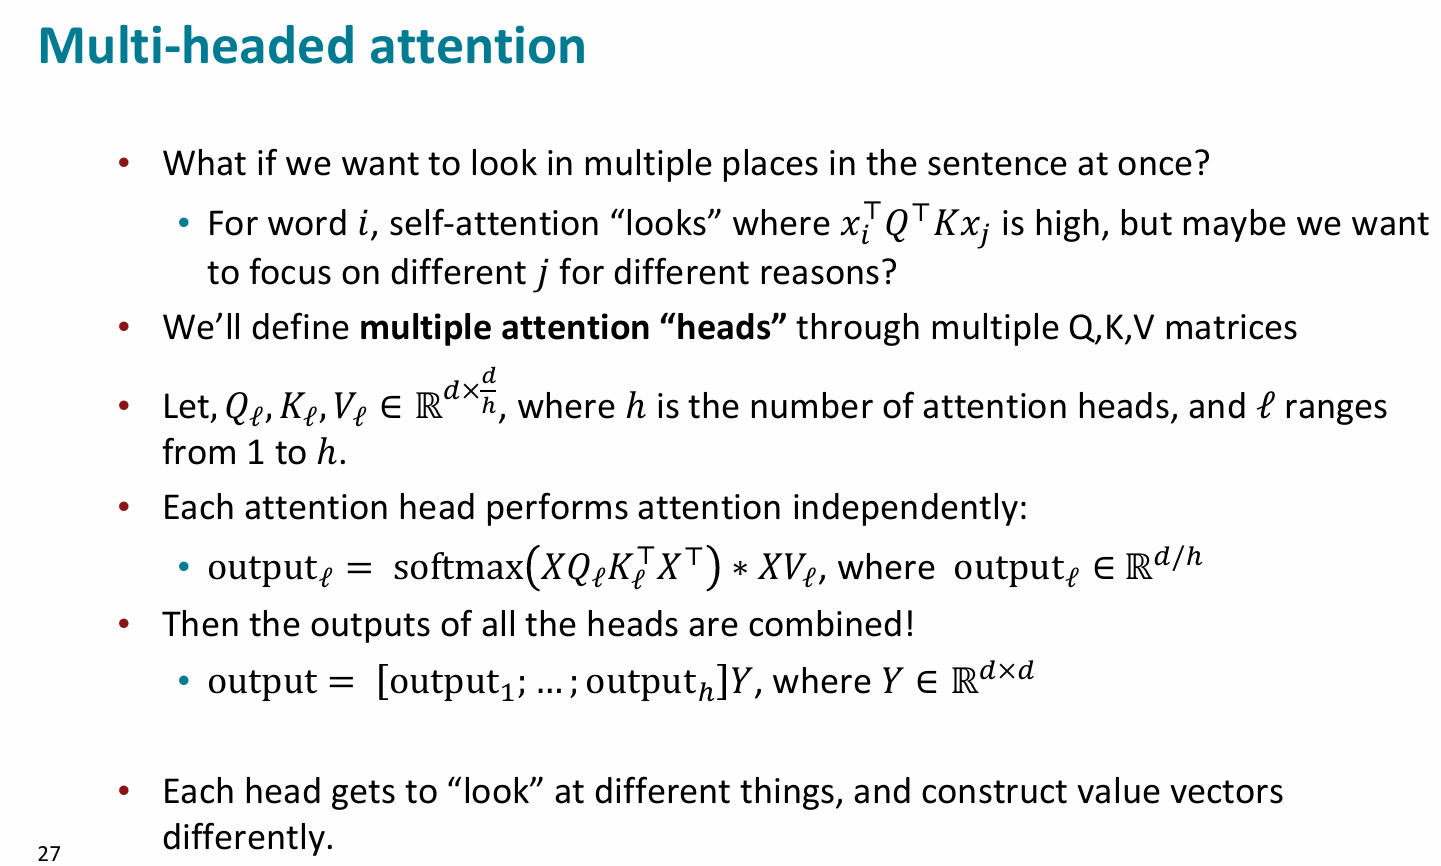

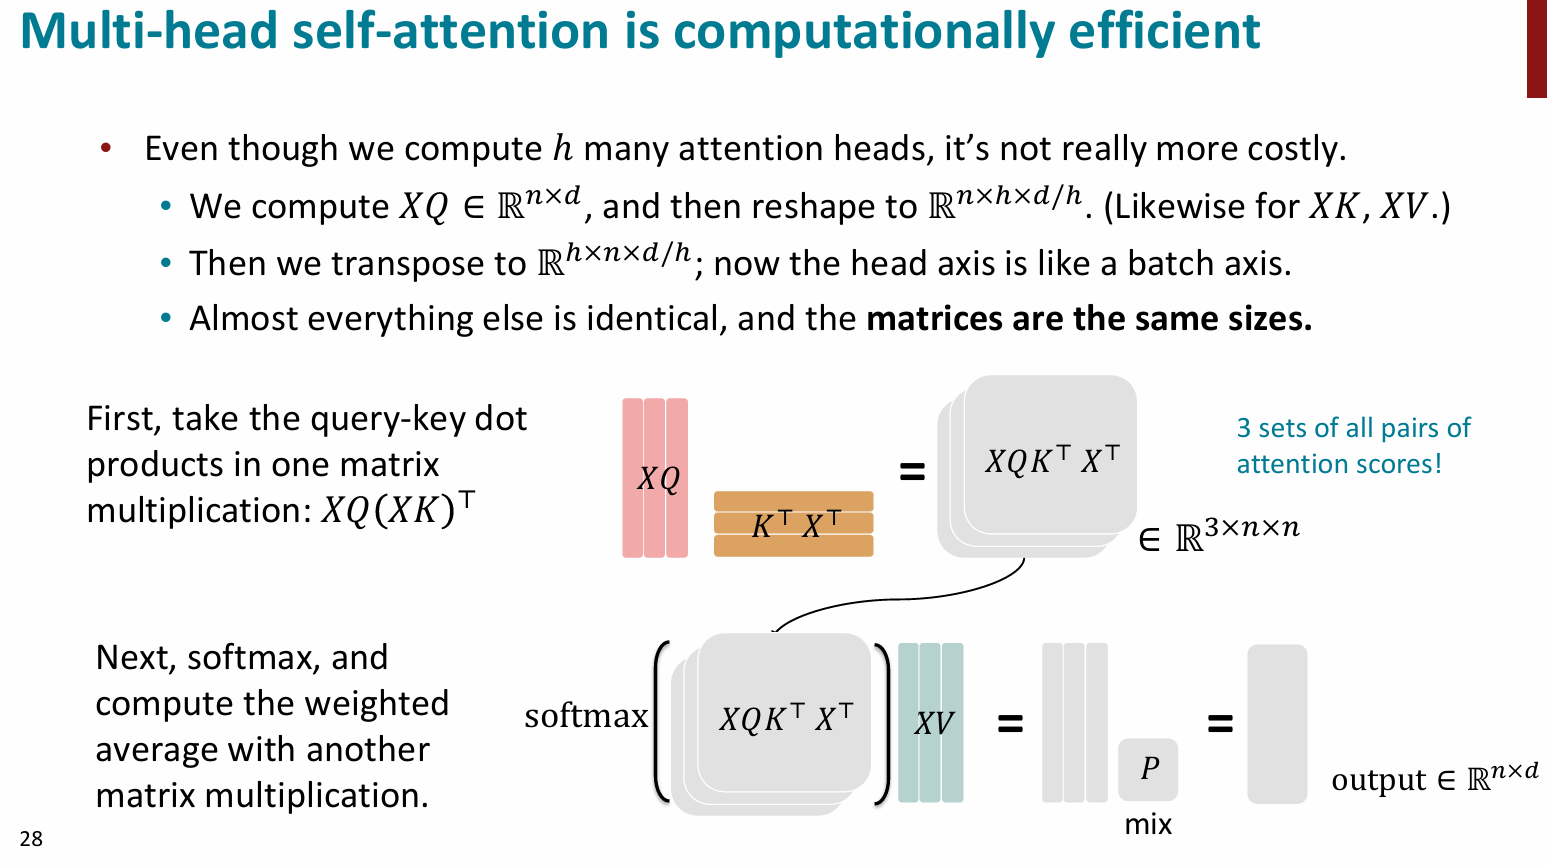


Source: https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1234/slides/cs224n-2023-lecture08-transformers.pdf